# Experiments for "DBSpan: Density-Based Spanner for Clustering Complex Data, With an Application to Persistence Diagrams"

To get started, we will do a little bit of path hackery to import the library.  There are better ways to do this, but for now, this is okay.

In [1]:
import random
import sys
import os
import math

libpath = os.path.abspath('..')
sys.path.insert(0, libpath)

import dbspan

We will do a bunch of comparisions of DBScan and DBSpan, so it will help if we have some code for making the algos

In [2]:
dgm_metric = dbspan.topology.DiagramMetric()

def dgm1_metric(dgm1, dgm2):
    return dgm_metric.bottleneck(dgm1[1], dgm2[1])

def make_algos(eps, min_samples, delta):
    algo_dbscan = dbspan.cluster.DBSCAN(metric=dgm1_metric, eps=eps, min_samples=min_samples)
    algo_dbspan = dbspan.cluster.DBSpan(metric=dgm1_metric, eps=eps, min_samples=min_samples, delta=delta)

    return algo_dbscan, algo_dbspan

## Experiment 1: Point clouds of things in 4D

First, we will create some tools for creating dgms of things in 4D.  Each function will produce a diagram from a rips filtration of a "noisy" sphere, torus, or swiss roll.

In [3]:
data_factory = dbspan.topology.PointSetDataFactory(seed=72330)
dgm_factory = dbspan.topology.DiagramFactory()

rng = random.Random(43081)

def make_sphere_dgm():
    points = data_factory.make_sphere(dim=4, num_points=100, noise=.1)
    return dgm_factory.make_from_point_set(points)

def make_torus_dgm():
    points = data_factory.make_torus(dim=4, num_points=100, noise=.1)
    return dgm_factory.make_from_point_set(points)

def make_swiss_roll_dgm():
    points = data_factory.make_swiss_roll(dim=4, num_points=100, noise=.1)
    return dgm_factory.make_from_point_set(points)

Now that we have some functions for creating data, let's create our data set that we will cluster:

In [4]:
num_dgms1 = 30
dgms1 = [make_sphere_dgm() for _ in range(num_dgms1)] \
    + [make_torus_dgm() for _ in range(num_dgms1)] \
    + [make_swiss_roll_dgm() for _ in range(math.floor(num_dgms1/2) - 1)]

And we are off!  Let's do some experiments

In [5]:
import time
import pandas as pd
from sklearn import metrics

def make_cache(true_labels, dbscan_time):
    return {
        'true_labels': true_labels,
        'dbscan_time': dbscan_time,
    }  
    
def run_experiment1(df, data, delta, eps, min_samples, cache=None):
    
    def add_row(df, delta, num_edges, max_edges, rand_index, dbscan_time, dbspan_time):
        data = [delta, rand_index, num_edges, max_edges, num_edges/max_edges, dbscan_time, dbspan_time, dbscan_time/dbspan_time]
        cols=['$\delta$', 'Rand index', 'Num Edges', 'maxEdges', '\% Possible Edges', 'T_DBSCAN', 'DBSpan time (sec)', 'Speedup']
        line = pd.DataFrame([data,], columns=cols)
        return pd.concat([df, line])
   
    # create the algos
    algo_dbscan, algo_dbspan = make_algos(eps=eps, min_samples=min_samples, delta=delta)

    # run the algos
    t0 = time.perf_counter()
    true_labels = cache['true_labels'] if cache else algo_dbscan.fit(data)
    t1 = time.perf_counter()
    dbspan_labels, dbg_data= algo_dbspan.fit(data, dbg=True)
    t2 = time.perf_counter()
    
    # pull out the dbg data for the analysis
    spanner = dbg_data['neighborhood'].spanner
    
    # prepare data for row
    rand_index = metrics.adjusted_rand_score(true_labels, dbspan_labels)
    dbscan_time = cache['dbscan_time'] if cache else t1 - t0
    dbspan_time = t2 - t1
    num_edges = spanner.number_of_edges()
    n = spanner.number_of_nodes()
    max_edges = n * (n-1) / 2
    
    # return row
    return add_row(df, delta, num_edges, max_edges, rand_index, dbscan_time, dbspan_time), \
        make_cache(true_labels, dbscan_time)

In [6]:
results1 = None
cache1 = None
eps1 = .3
min_samples1 = 15
for delta in [.1, 1, 10, 50, 100, 500, 1000]:
    results1, cache1 = run_experiment1(results1, dgms1, delta, eps1, min_samples1, cache=cache1)
    print(results1)

print(results1.style.to_latex())

   $\delta$  Rand index  Num Edges  maxEdges  \% Possible Edges   T_DBSCAN  \
0       0.1         1.0       2256    2701.0           0.835246  73.043168   

   DBSpan time (sec)   Speedup  
0          79.664465  0.916885  
   $\delta$  Rand index  Num Edges  maxEdges  \% Possible Edges   T_DBSCAN  \
0       0.1         1.0       2256    2701.0           0.835246  73.043168   
0       1.0         1.0       1137    2701.0           0.420955  73.043168   

   DBSpan time (sec)   Speedup  
0          79.664465  0.916885  
0          45.429457  1.607837  
   $\delta$  Rand index  Num Edges  maxEdges  \% Possible Edges   T_DBSCAN  \
0       0.1         1.0       2256    2701.0           0.835246  73.043168   
0       1.0         1.0       1137    2701.0           0.420955  73.043168   
0      10.0         1.0        475    2701.0           0.175861  73.043168   

   DBSpan time (sec)   Speedup  
0          79.664465  0.916885  
0          45.429457  1.607837  
0          19.385153  3.767995 

# Experiment 2

First, we will load in the data.  Since it is pretty small when gzipped, we keep it in the repo.  Let's unzip it

In [18]:
!mkdir -p data
!curl -J -L https://osf.io/4nwe9/download | tar xz --directory data
!echo "done!"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   459  100   459    0     0   1473      0 --:--:-- --:--:-- --:--:--  1509
100 10.3M  100 10.3M    0     0  2520k      0  0:00:04  0:00:04 --:--:-- 3949k
done!


In [22]:
import os
import numpy as np

exp2_data_dir = './data/experiment2/'
exp2_files = os.listdir(exp2_data_dir)

def read_file(name):
    file_name = os.path.join(exp2_data_dir, name)
    return [None, np.genfromtxt(file_name, delimiter=',')]

dgms2 = [ read_file(name) for name in exp2_files ]
print("Read in {} dgms".format(len(dgms2)))

Read in 8595 dgms


Next, let's look at the distribution of the number of points in the diagrams.  Personally, I don't know much about this data set, but MSU local expert (and super well guy that gave me these diagrams) Jordan Schupbach said that number of diagram points could be a useful to look at.  So let's look at the distribution of of the number of points.

(array([5941., 1750.,  560.,  190.,   53.,   40.,   29.,   15.,   11.,
           6.]),
 array([101. , 125.9, 150.8, 175.7, 200.6, 225.5, 250.4, 275.3, 300.2,
        325.1, 350. ]),
 <BarContainer object of 10 artists>)

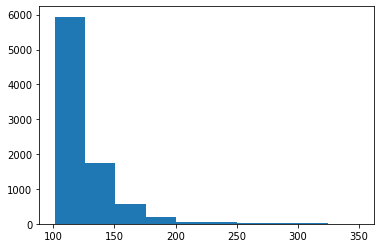

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

npts = np.array([dgm[1].shape[0] for dgm in dgms2])
plt.hist(npts)

So, it looks like we have a bunch of smallish dgms and a few very large diagrams.  To get a good distribution of diagram sizes, we will create three levels each containing the same number of diagrams.

In [10]:
dgms_by_level = [
    np.argwhere(npts < 150),
    np.argwhere((150 <= npts) & (npts < 200)),
    np.argwhere(200 <= npts),
]

def make_data2(dgms_per_level):
    rng = np.random.default_rng(seed=0)
    return [
        dgms2[idx]
        for level in dgms_by_level
        for idx in rng.choice(level.transpose()[0], size=dgms_per_level, replace=False)
    ]

small_data2 = make_data2(dgms_per_level=10)

Next, let's look at the pairwise distance matrix of a very small dataset.  (Note that the code below takes quite a while to run and stare at to pick some constants.  Uncomment to check out the distances).

In [11]:
# for i in range(len(small_data2)):
#     for j in range(i+1, len(small_data2)):
#         print(i, j, dgm1_metric(small_data2[i], small_data2[j]))

So, it looks like we have a bunch of close diagrams all with distance less than 10 and then some outliers.  So, let's cluster our points using and epsilon of 10 and see how it goes.

In [12]:
eps2 = 10
min_samples2 = 5

algo_dbscan = dbspan.cluster.DBSCAN(metric=dgm1_metric, eps=eps2, min_samples=min_samples2)

# run the algos
t0 = time.perf_counter()
true_labels = algo_dbscan.fit(small_data2)
t1 = time.perf_counter()
dbscan_time = t1-t0
cache2 = make_cache(true_labels, dbscan_time)
print(cache2)

{'true_labels': array([0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1]), 'dbscan_time': 279.8122000420699}


So, as we expected, we have a one cluster of diagrams and some noise.  Now, let's run the same experiments that we ran before to pick a good value for delta.

In [13]:
results2 = None
for delta in [.1, 1, 2, 3, 4, 5, 6]:
    results2, cache2 = run_experiment1(results2, small_data2, delta, eps2, min_samples2, cache=cache2)
    print(results2)
print(results2.style.to_latex())

   $\delta$  Rand index  Num Edges  maxEdges  \% Possible Edges  T_DBSCAN  \
0       0.1         1.0        435     435.0                1.0  279.8122   

   DBSpan time (sec)   Speedup  
0         286.322397  0.977263  
   $\delta$  Rand index  Num Edges  maxEdges  \% Possible Edges  T_DBSCAN  \
0       0.1    1.000000        435     435.0           1.000000  279.8122   
0       1.0    0.866529        282     435.0           0.648276  279.8122   

   DBSpan time (sec)   Speedup  
0         286.322397  0.977263  
0         181.501554  1.541652  
   $\delta$  Rand index  Num Edges  maxEdges  \% Possible Edges  T_DBSCAN  \
0       0.1    1.000000        435     435.0           1.000000  279.8122   
0       1.0    0.866529        282     435.0           0.648276  279.8122   
0       2.0    0.627675        208     435.0           0.478161  279.8122   

   DBSpan time (sec)   Speedup  
0         286.322397  0.977263  
0         181.501554  1.541652  
0         138.057328  2.026783  
   $\de

Excellent!!  So what did we learn, well, we can get a pretty good speed up and maintain pretty good accuracy if we pick delta just before the rand index dropps off.  Now let's see how large of a data set we can process.

In [17]:
delta2 = 1

import logging
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S')

def run_experiment2(df, num_per_level, delta, eps, min_samples):
  
    def add_row(df, num_dgms, num_edges, max_edges, rand_index, dbscan_time, dbspan_time):
        data = [num_dgms, rand_index, num_edges, max_edges, num_edges/max_edges, dbscan_time, dbspan_time, dbscan_time/dbspan_time]
        cols=['Num Dgms', 'Rand index', 'Num Edges', 'maxEdges', '\% Possible Edges', 'T_DBSCAN', 'DBSpan time (sec)', 'Speedup']
        line = pd.DataFrame([data,], columns=cols)
        return pd.concat([df, line])
  
    d2 = make_data2(dgms_per_level=num_per_level)
    
    algo_dbscan, algo_dbspan = make_algos(eps=eps, min_samples=min_samples, delta=delta)

    # run the algos
    t0 = time.perf_counter()
    dbspan_labels, dbg_data= algo_dbspan.fit(d2, dbg=True)
    dbspan_time = time.perf_counter() - t0

    # prep dbspan data
    spanner = dbg_data['neighborhood'].spanner    
    num_edges = spanner.number_of_edges()
    n = spanner.number_of_nodes()
    max_edges = n * (n-1) / 2
    
    logging.info((n, dbspan_time, num_edges, max_edges))
    
    # run dbscan
    t1 = time.perf_counter()
    true_labels = algo_dbscan.fit(d2)
    dbscan_time = time.perf_counter() - t1
    
    # prepare data for row
    rand_index = metrics.adjusted_rand_score(true_labels, dbspan_labels)   

    # return row
    return add_row(df, n, num_edges, max_edges, rand_index, dbscan_time, dbspan_time)
    
results2b = None
eps2 = 10
min_samples2 = 5
for i in [10, 15, 20, 25, 30, 35, 40]:
    results2b = run_experiment2(results2b, i, delta2, eps2, min_samples2)
    print(results2b)

print(results2b.style.to_latex())

2022-04-26 22:57:48 INFO     (30, 185.1409450409701, 285, 435.0)


   Num Dgms  Rand index  Num Edges  maxEdges  \% Possible Edges    T_DBSCAN  \
0        30         1.0        285     435.0           0.655172  283.248509   

   DBSpan time (sec)   Speedup  
0         185.140945  1.529907  


2022-04-26 23:09:41 INFO     (45, 429.65287029207684, 656, 990.0)


   Num Dgms  Rand index  Num Edges  maxEdges  \% Possible Edges    T_DBSCAN  \
0        30         1.0        285     435.0           0.655172  283.248509   
0        45         1.0        656     990.0           0.662626  654.448212   

   DBSpan time (sec)   Speedup  
0         185.140945  1.529907  
0         429.652870  1.523202  


2022-04-26 23:59:52 INFO     (60, 656.3668717920082, 1141, 1770.0)


   Num Dgms  Rand index  Num Edges  maxEdges  \% Possible Edges     T_DBSCAN  \
0        30    1.000000        285     435.0           0.655172   283.248509   
0        45    1.000000        656     990.0           0.662626   654.448212   
0        60    0.793718       1141    1770.0           0.644633  1007.534399   

   DBSpan time (sec)   Speedup  
0         185.140945  1.529907  
0         429.652870  1.523202  
0         656.366872  1.535017  


2022-04-27 02:20:49 INFO     (75, 998.3531174999662, 1525, 2775.0)


   Num Dgms  Rand index  Num Edges  maxEdges  \% Possible Edges     T_DBSCAN  \
0        30    1.000000        285     435.0           0.655172   283.248509   
0        45    1.000000        656     990.0           0.662626   654.448212   
0        60    0.793718       1141    1770.0           0.644633  1007.534399   
0        75    0.941231       1525    2775.0           0.549550  1762.891531   

   DBSpan time (sec)   Speedup  
0         185.140945  1.529907  
0         429.652870  1.523202  
0         656.366872  1.535017  
0         998.353117  1.765800  


2022-04-27 04:32:22 INFO     (90, 1369.5764904579846, 2250, 4005.0)


   Num Dgms  Rand index  Num Edges  maxEdges  \% Possible Edges     T_DBSCAN  \
0        30    1.000000        285     435.0           0.655172   283.248509   
0        45    1.000000        656     990.0           0.662626   654.448212   
0        60    0.793718       1141    1770.0           0.644633  1007.534399   
0        75    0.941231       1525    2775.0           0.549550  1762.891531   
0        90    0.901672       2250    4005.0           0.561798  2435.761776   

   DBSpan time (sec)   Speedup  
0         185.140945  1.529907  
0         429.652870  1.523202  
0         656.366872  1.535017  
0         998.353117  1.765800  
0        1369.576490  1.778478  


2022-04-27 06:31:02 INFO     (105, 1942.8771660840139, 2964, 5460.0)


   Num Dgms  Rand index  Num Edges  maxEdges  \% Possible Edges     T_DBSCAN  \
0        30    1.000000        285     435.0           0.655172   283.248509   
0        45    1.000000        656     990.0           0.662626   654.448212   
0        60    0.793718       1141    1770.0           0.644633  1007.534399   
0        75    0.941231       1525    2775.0           0.549550  1762.891531   
0        90    0.901672       2250    4005.0           0.561798  2435.761776   
0       105    0.958183       2964    5460.0           0.542857  3476.131299   

   DBSpan time (sec)   Speedup  
0         185.140945  1.529907  
0         429.652870  1.523202  
0         656.366872  1.535017  
0         998.353117  1.765800  
0        1369.576490  1.778478  
0        1942.877166  1.789167  


2022-04-27 09:06:51 INFO     (120, 2269.6275037919404, 3523, 7140.0)


   Num Dgms  Rand index  Num Edges  maxEdges  \% Possible Edges     T_DBSCAN  \
0        30    1.000000        285     435.0           0.655172   283.248509   
0        45    1.000000        656     990.0           0.662626   654.448212   
0        60    0.793718       1141    1770.0           0.644633  1007.534399   
0        75    0.941231       1525    2775.0           0.549550  1762.891531   
0        90    0.901672       2250    4005.0           0.561798  2435.761776   
0       105    0.958183       2964    5460.0           0.542857  3476.131299   
0       120    0.857597       3523    7140.0           0.493417  4457.904083   

   DBSpan time (sec)   Speedup  
0         185.140945  1.529907  
0         429.652870  1.523202  
0         656.366872  1.535017  
0         998.353117  1.765800  
0        1369.576490  1.778478  
0        1942.877166  1.789167  
0        2269.627504  1.964157  
\begin{tabular}{lrrrrrrrr}
 & Num Dgms & Rand index & Num Edges & maxEdges & \% Possible Edges 